In [1]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
import re
import time
from selenium import webdriver
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
#This part need to install chrome driver to ensure the demo is successful.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--disable-infobars")
driver = webdriver.Chrome('C:/chromedriver/chromedriver.exe',chrome_options=chrome_options)

def chrome_driver(game_id):
    driver.get('https://steamcommunity.com/app/'+game_id+'/reviews/?filterLanguage=english&p=1&browsefilter=trendweek')
    count=0
    page_num=[]
    while count<100:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.15)
        count+=1
        page=BeautifulSoup(driver.page_source, 'lxml')
        page_num.append(str(page).count('div id="page'))
        d = {x:page_num.count(x) for x in page_num}
        if d[max(d.keys())]>9:
            break
    #get the whole page that we want
    #driver.close()  
    #extract useful information from page
    page=BeautifulSoup(driver.page_source, 'lxml')    
    raw_review=page.find_all(class_="apphub_CardTextContent") 
    return raw_review
    
text=chrome_driver('322330')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: use options instead of chrome_options
  This is separate from the ipykernel package so we can avoid doing imports until


### Data

In [2]:
data=pd.read_csv('scoredata.csv')
text=data['text']

In [3]:
def preprocess(x):
    a=re.sub(r'\t*|\n','',str(x)).split('\r')
    b=[]
    for i in a:
        b.append(re.sub(r'Posted:','*',i).split('*')[0].strip())
    b=[b for b in b if b]
    return b

In [4]:
text[0]

' \nPosted: September 2, 2012\r\n\t\t\t\t\t\t\t\t\t\t\t\tits k\t\t\t \nPosted: May 30, 2017\r\n\t\t\t\t\t\t\t\t\t\t\t\tIf you want to have a great life with jobs, moneys, girl, etc, don\'t play this game.\t\t\t \nPosted: February 3, 2018\r\n\t\t\t\t\t\t\t\t\t\t\t\tRuins your social life.Makes you sad and happy at the same time. Recommended for people who do not want a life.\t\t\t \nPosted: June 30, 2014\r\n\t\t\t\t\t\t\t\t\t\t\t\tDOTA 2, THE SEQUEL TO THE AWARD WINNING DOTASTARRING:Sven StaffaniRiki Martin2 PuckStevie NyxJackie ChenHrithik RoshanSlark WalbergJoaquin PhoenixJustin TimbersawJustin WeaverClinkz EastwoodJohn LinaJim CarryTom TanksNatalie SupportmanSarah Jessica Ganker\ufeffAlch PacinoMatt DagonChristian BaneEllen PudgeEd HarrassEddie MorphlingMorgan FiendmanSnoop LionBruce LichBen SladarRobert De Ny-roLeonardo DisRuptioRussel DroweDazzle WashingtonMick Jaggernaut50 CentaurMalcolm AxeOrlando DoomMirana KerrZeus WillisDIRECTED BY:M. Night StalkerStanley RubickCOMING SOON TO 

In [5]:
preprocess(text[0])

['its k',
 "If you want to have a great life with jobs, moneys, girl, etc, don't play this game.",
 'Ruins your social life.Makes you sad and happy at the same time. Recommended for people who do not want a life.',
 'DOTA 2, THE SEQUEL TO THE AWARD WINNING DOTASTARRING:Sven StaffaniRiki Martin2 PuckStevie NyxJackie ChenHrithik RoshanSlark WalbergJoaquin PhoenixJustin TimbersawJustin WeaverClinkz EastwoodJohn LinaJim CarryTom TanksNatalie SupportmanSarah Jessica Ganker\ufeffAlch PacinoMatt DagonChristian BaneEllen PudgeEd HarrassEddie MorphlingMorgan FiendmanSnoop LionBruce LichBen SladarRobert De Ny-roLeonardo DisRuptioRussel DroweDazzle WashingtonMick Jaggernaut50 CentaurMalcolm AxeOrlando DoomMirana KerrZeus WillisDIRECTED BY:M. Night StalkerStanley RubickCOMING SOON TO A COMPUTER NEAR YOU',
 'You either quit while you are the feeder or play long enough to see yourself become toxic.',
 'good game',
 "Skipped classes thanks to Dota.Learned to gamble thanks to Dota.Learned to swear in 

In [9]:
clean_text=[]
for i in range(len(text)):
    clean_text.append(preprocess(text[i]))

In [10]:
new_data=data.copy()
new_data['text']=clean_text

In [11]:
new_data.to_csv('newdata.csv', index=False)

In [12]:
a=pd.read_csv('newdata.csv')
a.head()

,Unnamed: 0,id,text,score
0,0,570,"['its k', ""If you want to have a great life wi...",90
1,1,730,"['I NOT CAN PLAY', 'Very nice game but there a...",83
2,2,271590,"['After more than 1000 hours, 3 shark cards in...",96
3,3,440,"['I first downloaded this game on February 22,...",92
4,4,252950,"['Rocket League is less of a ""sports game"" and...",86


In [14]:
def text_normalizer(text):
    text=text.lower()
    text=text.split(' ') 
    my_stopwords=set(stopwords.words('english')+list(string.punctuation)+
                     ["can't",'would','u','cant','dont','im','ive'])
    text=[w for w in text if w not in my_stopwords]
    text1=[]
    for w in text:
        text1.append(re.sub('[^A-Za-z]+', '', w))
    porter=nltk.PorterStemmer()   
    text=[porter.stem(t) for t in text1]
    text=[w for w in text if w not in my_stopwords]
    text=[w for w in text if w]
    return ' '.join(text)

text_normalizer(clean_text[0][0])

'k'

In [15]:
def token_word(x):    
    tok_word=[]
    for sent in clean_text[int(x)]:
        tok_word.append(text_normalizer(sent))
    return tok_word

In [16]:
final_word=[]
for i in range(len(clean_text)):
    final_word.append(token_word(i))

In [17]:
final_word[0]

['k',
 'want great life job money girl etc play game',
 'ruin social lifemak sad happi time recommend peopl want life',
 'dota sequel award win dotastarringsven staffaniriki martin puckstevi nyxjacki chenhrithik roshanslark walbergjoaquin phoenixjustin timbersawjustin weaverclinkz eastwoodjohn linajim carrytom tanksnatali supportmansarah jessica gankeralch pacinomatt dagonchristian baneellen pudge harrasseddi morphlingmorgan fiendmansnoop lionbruc lichben sladarrobert de nyroleonardo disruptiorussel drowedazzl washingtonmick jaggernaut centaurmalcolm axeorlando doommirana kerrzeu willisdirect bym night stalkerstanley rubickcom soon comput near',
 'either quit feeder play long enough see becom toxic',
 'good game',
 'skip class thank dotalearn gambl thank dotalearn swear differ languag thank dotabecam racist thank dotaal ruin life simul recommend tri kill cancer curedsea dota commun',
 'good',
 'caus anxieti problem low self esteem tourett syndrom mood swing bipolar disord breakdown rel

In [18]:
### combine all commons together per game
final_text=[]
for i in range(len(final_word)):
    final_text.append(' '.join(final_word[i]))

In [19]:
final_text[0]

'k want great life job money girl etc play game ruin social lifemak sad happi time recommend peopl want life dota sequel award win dotastarringsven staffaniriki martin puckstevi nyxjacki chenhrithik roshanslark walbergjoaquin phoenixjustin timbersawjustin weaverclinkz eastwoodjohn linajim carrytom tanksnatali supportmansarah jessica gankeralch pacinomatt dagonchristian baneellen pudge harrasseddi morphlingmorgan fiendmansnoop lionbruc lichben sladarrobert de nyroleonardo disruptiorussel drowedazzl washingtonmick jaggernaut centaurmalcolm axeorlando doommirana kerrzeu willisdirect bym night stalkerstanley rubickcom soon comput near either quit feeder play long enough see becom toxic good game skip class thank dotalearn gambl thank dotalearn swear differ languag thank dotabecam racist thank dotaal ruin life simul recommend tri kill cancer curedsea dota commun good caus anxieti problem low self esteem tourett syndrom mood swing bipolar disord breakdown relationship rage erect racism defin

In [21]:
data2=data.copy()
data2['text']=final_text
data2.to_csv('vect_word.csv', index=False)

In [22]:
data3=pd.read_csv('vect_word.csv')
data3['text'][0]

'k want great life job money girl etc play game ruin social lifemak sad happi time recommend peopl want life dota sequel award win dotastarringsven staffaniriki martin puckstevi nyxjacki chenhrithik roshanslark walbergjoaquin phoenixjustin timbersawjustin weaverclinkz eastwoodjohn linajim carrytom tanksnatali supportmansarah jessica gankeralch pacinomatt dagonchristian baneellen pudge harrasseddi morphlingmorgan fiendmansnoop lionbruc lichben sladarrobert de nyroleonardo disruptiorussel drowedazzl washingtonmick jaggernaut centaurmalcolm axeorlando doommirana kerrzeu willisdirect bym night stalkerstanley rubickcom soon comput near either quit feeder play long enough see becom toxic good game skip class thank dotalearn gambl thank dotalearn swear differ languag thank dotabecam racist thank dotaal ruin life simul recommend tri kill cancer curedsea dota commun good caus anxieti problem low self esteem tourett syndrom mood swing bipolar disord breakdown relationship rage erect racism defin

In [23]:
X_train,X_test,y_train,y_test=train_test_split(data3['text'],
                                              data3['score'],
                                              test_size=0.25,
                                              random_state=0)

In [24]:
X_train=X_train.values.astype('U')
X_test=X_test.values.astype('U')

In [25]:
vect=CountVectorizer(ngram_range=(1,1),min_df=5).fit(X_train)
vect.get_feature_names()
X_train_vectorized = vect.transform(X_train)
full_text_matrix=vect.transform(data3['text'].values.astype('U'))

In [27]:
text_vector=pd.DataFrame(full_text_matrix.toarray(),columns=vect.get_feature_names())
text_vector.head()

,aa,aaa,aaagam,aabout,aand,ab,abandon,abandond,abandonwar,abbrevi,...,zen,zenith,zerg,zero,zip,zombi,zone,zoo,zoom,zulu
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,2,0,1,0,0,1,0,0,0,...,0,0,0,1,0,2,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
full_text_matrix=vect.transform(data3['text'].values.astype('U'))
full_text_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 0]], dtype=int64)

In [31]:
vect.get_feature_names()

['aa',
 'aaa',
 'aaagam',
 'aabout',
 'aand',
 'ab',
 'abandon',
 'abandond',
 'abandonwar',
 'abbrevi',
 'abc',
 'aberr',
 'abhorr',
 'abid',
 'abil',
 'abilit',
 'abilti',
 'abit',
 'abl',
 'ablaz',
 'abliti',
 'abnorm',
 'aboard',
 'abomin',
 'abondon',
 'abort',
 'abou',
 'abound',
 'abouta',
 'abouti',
 'aboutit',
 'aboutth',
 'abov',
 'aboveaverag',
 'abovement',
 'abridg',
 'abroad',
 'abrupt',
 'abruptli',
 'absenc',
 'absent',
 'absolut',
 'absolutley',
 'absolutli',
 'absorb',
 'abstract',
 'absurd',
 'absurdli',
 'abund',
 'abus',
 'abysm',
 'abyss',
 'ac',
 'academ',
 'academi',
 'acc',
 'acceler',
 'accent',
 'accentu',
 'accept',
 'acces',
 'access',
 'accessori',
 'accid',
 'accident',
 'accidentali',
 'accidentlyreview',
 'acclaim',
 'accommod',
 'accomod',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accross',
 'accru',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accustom',
 'ace',
 'acess',
 'ach',
 'acheiv',
 'achiev',
 'achiv',
 'acid',
 

In [33]:
model = linear_model.LinearRegression()
model.fit(X_train_vectorized, y_train)
score_pred = model.predict(vect.transform(X_test))
predict=np.round(score_pred,0)

In [34]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, predict))
np.corrcoef(y_test, predict)

Mean squared error: 22.19
Variance score: -0.04


array([[1.        , 0.40703106],
       [0.40703106, 1.        ]])

In [35]:
y_test.values
predict=np.round(score_pred,0)
score_comp=pd.DataFrame({'real':y_test,'predict':predict})
score_comp

,real,predict
294,90,95.0
65,88,79.0
15,85,90.0
272,85,86.0
140,77,75.0
153,85,83.0
101,85,85.0
234,85,87.0
63,81,82.0
159,86,86.0


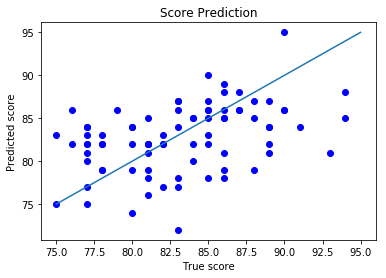

In [37]:
x = np.linspace(75, 95, 1000)
plt.scatter(y_test.values, predict, color='blue')
plt.plot(x, x + 0, linestyle='solid')
plt.title('Score Prediction')
plt.xlabel('True score')
plt.ylabel('Predicted score')
#plt.show()
plt.savefig('score_pred.png', format='png')